In [1]:
import pandas as pd
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
df1 = pd.read_csv("Data_Description2.csv")

# reviews = df['review'].tolist()
# reviews[:10]
df1

,Title,Description,class
0,jokes,Have you ever started to tell a joke only to f...,0
1,news,"WASHINGTON — Rep. Thomas Massie, R-K.Y., is fa...",0
2,good resturant,"I found a good resturant near the 4th street, ...",0
3,needs help,"my math assignment is so hard, who can help me",0
4,Are you in marketing? I have your bonus check!,I recently launched a multi-service company th...,1
...,...,...,...
1061,looking for girlfriend,"I am 22, and looking for a girlfriend",0
1062,title,I miss my ex wife,0
1063,gambling,want a chance to win $100 m? here is the big c...,0
1064,charged,A 15-year-old boy was charged Tuesday in the s...,0


In [2]:
df2 = pd.read_csv('Resume.csv')
df2['class'] = [1 for x in range(len(df2))]
df3 = pd.read_csv('Activity.csv')
df3['class'] = [0 for x in range(len(df3))]
df4 = pd.read_csv('Community.csv')
df4['class'] = [0 for x in range(len(df4))]

In [3]:
df = pd.concat([df1, df2, df3, df4],ignore_index=True)
df['review'] = df['Title'].str.cat(df['Description'],sep = '. ')
df.drop(['Unnamed: 0', 'Unnamed: 3','Unnamed: 4'], axis = 1, inplace = True)
df.dropna(inplace=True)
reviews = df['review'].tolist()
df.iloc[1287]

Title                I need a job as Dishwasher or store stocker
Description    I'm seeking a full-time or part-time position ...
class                                                          1
review         I need a job as Dishwasher or store stocker. I...
Name: 1287, dtype: object

In [4]:
def clean_review_list(reviews):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stemmer = nltk.stem.PorterStemmer()
    t_d_matrix_words = []
    for review in reviews:
        review_token = nltk.word_tokenize(re.sub(r"(&gt|&lt|&#39|&quot)", "", review))    
        r_token=[]
        for token in review_token:
            token = stemmer.stem(token.lower())
            lemmatized_token = lemmatizer.lemmatize(token.lower()) 
            if not lemmatized_token in stopwords.words('English') and lemmatized_token.isalpha():
                r_token.append(lemmatized_token)
        t_d_matrix_words.append(r_token)
    clean_review =[]
    for i in range(len(t_d_matrix_words)):
        clean_review.append(" ".join(t_d_matrix_words[i]))
    return clean_review

In [6]:
clean_review = clean_review_list(reviews)
clean_review

['joke ever start tell joke onli forget punchlin halfway forget could funni one want suffer embarrass mess good joke especi one funniest joke time sometim need get quick laugh demand better way one short joke pull back pocket need someth funni fli along funniest call joke even someth get small folk giggl short joke kid',
 'news washington thoma massi face backlash democrat post christma photo hi famili smile pose assort gun day four teenag kill shoot michigan high school merri christma p santa plea bring ammo massi wrote saturday twitter',
 'good restur found good restur near street food delici',
 'need help math assign hard help',
 'market bonu check recent launch compani provid client websit design app develop cm shop cart offic new york well abroad run oper search potenti partner market help becom web servic provid organ guarante compens everi project absolut addit inform interest seriou candid onli plea',
 'licens earli childhood earli year teacher retir doe experienc mentor begin 

In [7]:
# Use Tfidf, for review that account for a small portion, maybe tfidf can capture more information due to the reversed frequency of idf
# make words become reviews again
# tfidfvectorize
tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
tfidfvectorizer.fit(clean_review)
len(tfidfvectorizer.vocabulary_)

52632

In [8]:
# tfidf transform each review to vector
tfidfvectorized_review = tfidfvectorizer.transform(clean_review)
tfidfvec = tfidfvectorized_review.toarray()
tfidfvec.shape

(4000, 52632)

In [10]:
# try clustering
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
binaryclass = KMeans(n_clusters=2, random_state=0).fit(tfidfvec)
acc_cluster = accuracy_score(df['class'], binaryclass.labels_)
print("Kmeans Accuracy: {:.2f}%".format(acc_cluster*100))

Kmeans Accuracy: 73.92%


In [11]:
# Part 1 Unsupervised model not work, we manully give dataset a class, and train the data, see if the model is good enough to predict category
# split data
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(tfidfvec,df['class'],test_size=0.2)

In [12]:
# use SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
SVMmodel = LinearSVC()
# training
SVMmodel.fit(train_x, train_y)
topic_pred_SVM = SVMmodel.predict(test_x)
# evaluation
acc_SVM = accuracy_score(test_y, topic_pred_SVM)
print("SVM model Accuracy:{:.2f}%".format(acc_SVM*100))

SVM model Accuracy:95.00%


In [13]:
# Supervised Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
DTmodel = DecisionTreeClassifier()
RFmodel = RandomForestClassifier(n_estimators=50, max_depth=3,
bootstrap=True, random_state=0) ## number of trees and number of layers/depth
# training
DTmodel.fit(train_x, train_y)
y_pred_DT = DTmodel.predict(test_x)
RFmodel.fit(train_x, train_y)
y_pred_RF = RFmodel.predict(test_x)
# evaluation
acc_DT = accuracy_score(test_y, y_pred_DT)
print("Decision Tree Model Accuracy: {:.2f}%".format(acc_DT*100))
acc_RF = accuracy_score(test_y, y_pred_RF)
print("Random Forest Model Accuracy: {:.2f}%".format(acc_RF*100))

Decision Tree Model Accuracy: 88.62%
Random Forest Model Accuracy: 60.50%


In [14]:
# Supervised Logistic
from sklearn.linear_model import LogisticRegression
Logitmodel = LogisticRegression()
# training
Logitmodel.fit(train_x, train_y)
y_pred_logit = Logitmodel.predict(test_x)
# evaluation
from sklearn.metrics import accuracy_score
acc_logit = accuracy_score(test_y, y_pred_logit)
print("Logit model Accuracy:: {:.2f}%".format(acc_logit*100))

Logit model Accuracy:: 94.62%


In [15]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_x, train_y)
y_pred_knn = neigh.predict(test_x)
# evaluation
acc_knn = accuracy_score(test_y, y_pred_knn)
print("KNN model Accuracy:: {:.2f}%".format(acc_knn*100))

KNN model Accuracy:: 91.38%


In [16]:
# Use SVM, the best performed model to predict the exist data.
topic_pred_SVM = SVMmodel.predict(tfidfvec[0:2196])
acc_SVM = accuracy_score(df['class'][0:2196], topic_pred_SVM)
acc_SVM

0.9918032786885246

In [17]:
dft = pd.read_excel("Test.xlsx")
dft['review'] = dft['Title'].str.cat(dft['Description'],sep = '. ')
testreviews = dft['review'].tolist()
tclean_review = clean_review_list(testreviews)

In [18]:
tfidfvectorized_reviewt = tfidfvectorizer.transform(tclean_review)
tfidfvect = tfidfvectorized_reviewt.toarray()

In [19]:
testtopic_pred_SVM = SVMmodel.predict(tfidfvect)
dft['predict'] = testtopic_pred_SVM
acc_SVM = accuracy_score(dft['class'], testtopic_pred_SVM)
acc_SVM

1.0

In [20]:
# Part 2 Use unsupervised model, to figure out the if its a resume or just give a classification for diffierent type of job searching review
from sklearn.feature_extraction.text import CountVectorizer
# [:2196] are all from resume
# create df only have resume
df_resume = df.iloc[:2196]
topic_pred_SVM = SVMmodel.predict(tfidfvec[0:2196])
df_resume['recog'] = topic_pred_SVM
df_resume = df_resume[df_resume['recog'] == 1]
resume_review = df_resume['review'].tolist()

C:\Users\Jason\AppData\Local\Temp/ipykernel_25872/3836372640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resume['recog'] = topic_pred_SVM


In [22]:
# transform clean resume review to vec
clean_review_r = clean_review_list(resume_review)
print(clean_review_r)

['market bonu check recent launch compani provid client websit design app develop cm shop cart offic new york well abroad run oper search potenti partner market help becom web servic provid organ guarante compens everi project absolut addit inform interest seriou candid onli plea', 'licens earli childhood earli year teacher retir doe experienc mentor begin teacher via teach fellow program brooklyn colleg daycar educ directorseek act consult owner start daycar help aspect licens set purchas suppli recruit interview hire staff curriculum creation may interest look forward talk safe', 'student hi servic year mostli famili friend nyc whatev budget help send someon thank', 'respons reliabl admin profession seek employ respons reliabl admin profession seek employ offic assist person assist custom servic data entri run resum profession excel offic administr bookkeep train highli motiv strong work orient outstand organiz analyt skill quick learner abil manag project priorit task creat workflow

In [23]:
# use new tfidf model to transform the review because those review already classified as resume, so new model will be good
tfidfvectorizer2 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
tfidfvectorizer2.fit(clean_review_r)
tfidfvectorized_resume_review = tfidfvectorizer2.transform(clean_review_r)
tfidf_rvec = tfidfvectorized_resume_review.toarray()
tfidf_rvec.shape

(2169, 36316)

In [37]:
terms = tfidfvectorizer2.get_feature_names()

In [30]:
# Unsupervised LDA
from sklearn.decomposition import LatentDirichletAllocation
import gensim

lda = LatentDirichletAllocation(n_components=12).fit(tfidf_rvec)
# for topic_idx, topic in enumerate(lda.components_):
    # print("Topic %d:" % (topic_idx+1))
    # print(" ".join([terms[i] for i in topic.argsort()[:-4-1:-1]]))

In [38]:
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx+1))
    print(" ".join([terms[i] for i in topic.argsort()[:-4-1:-1]]))

Topic 1:
work look job experi
Topic 2:
electrician carpent sst labor
Topic 3:
want resum resum job driver look cdl driver
Topic 4:
holiday paint holiday window window paint
Topic 5:
wire certifi home dont money wire
Topic 6:
math thesi ebay ebay amazon
Topic 7:
real estat financi estat van
Topic 8:
clean quickbook servic avail bookkeep
Topic 9:
houseman mover market fashion
Topic 10:
quickbook loan finish sale
Topic 11:
clean flower outdoor access
Topic 12:
look job job look translat


In [ ]:
a = lda.transform(t_d_matrix_v[0])
# print(lda.components_)
a.argsort()[0][-1]

In [39]:
#step 4
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(3, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

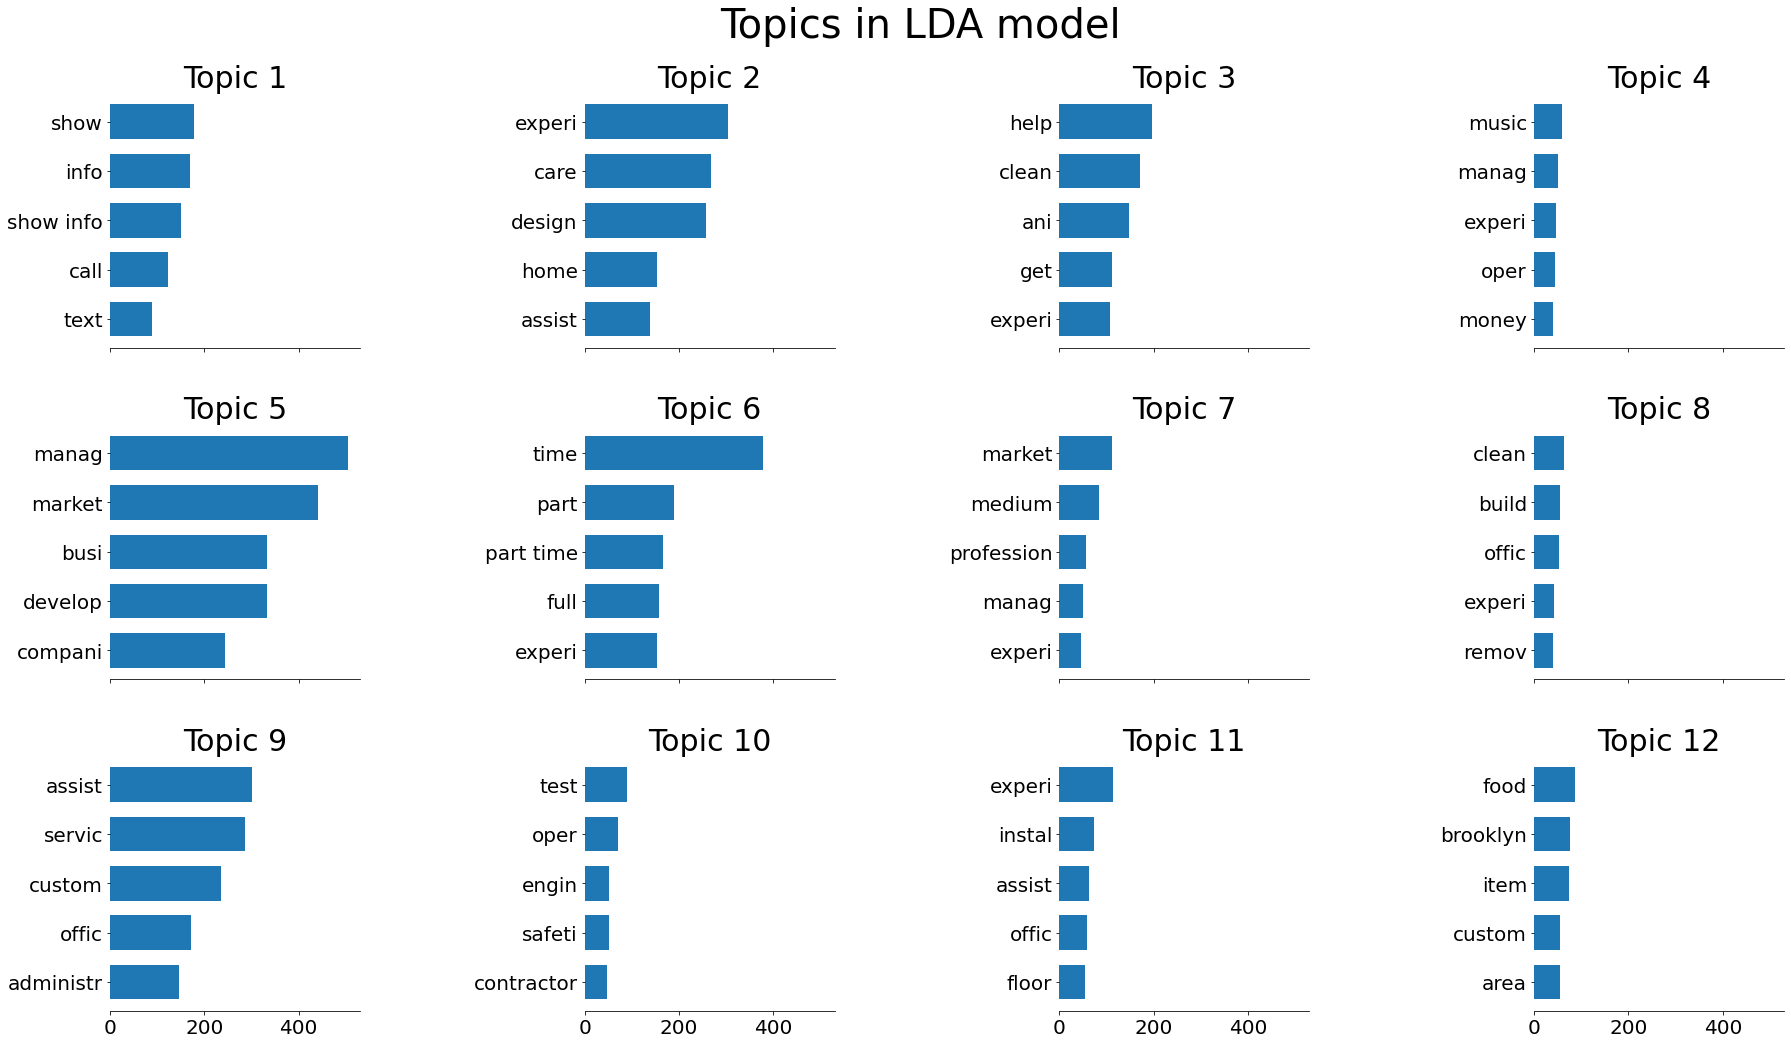

In [155]:
from time import time
import matplotlib.pyplot as plt
plot_top_words(lda,terms,5,"Topics in LDA model")

In [156]:
# transform matrix in to topic distribution
topicmatrix = lda.transform(t_d_matrix_v)
topicmatrix[2]

array([0.23574667, 0.00490223, 0.71523278, 0.00490201, 0.00490212,
       0.00490212, 0.00490199, 0.00490201, 0.00490206, 0.00490199,
       0.004902  , 0.00490201])

In [157]:
# get the most probable topic of each review and add to the df
topiclist = []
for i in range(len(topicmatrix)):
    topiclist.append(topicmatrix[i].argsort()[-1])
df_resume['LDA_class'] = topiclist
df_resume = df_resume.drop('review',axis=1)

In [30]:
# save to csv
df_resume.to_csv('ClusteredReview.csv')

In [167]:
df_resume['review'] = df_resume['Title'].str.cat(df_resume['Description'],sep = '. ')
df_resume = df_resume.reset_index().drop('index',axis = 1)
df_resume

,Title,Description,class,recog,KNN_class,LDA_class,review
0,Are you in marketing? I have your bonus check!,I recently launched a multi-service company th...,1,1,3,4,Are you in marketing? I have your bonus check!...
1,Licensed Early Childhood Teacher/Education Dir...,"Early years teacher, retired DOE, experienced ...",1,1,3,4,Licensed Early Childhood Teacher/Education Dir...
2,Student web/design/marketing,"Hi, I'm doing web/design/marketing services fo...",1,1,3,2,"Student web/design/marketing. Hi, I'm doing we..."
3,Responsible and Reliable Admin Professional S...,Responsible and reliable Admin professional se...,1,1,0,8,Responsible and Reliable Admin Professional S...
4,Recent Studio Tech Student-seeks video switchi...,Recently trained audio/video studio technician...,1,1,3,4,Recent Studio Tech Student-seeks video switchi...
...,...,...,...,...,...,...,...
2156,*EXPERIENCED PRIVATE CHAUFFEUR / DRIVER 4 HIRE...,"*NO TLC, ONLY CLASS ""E"" LICENSE IF YOU ARE IN ...",1,1,0,8,*EXPERIENCED PRIVATE CHAUFFEUR / DRIVER 4 HIRE...
2157,Bilingual Administrative Assistant,Administrative Assistant who has many years of...,1,1,0,10,Bilingual Administrative Assistant. Administra...
2158,Bilingual Administrative Assistant,Administrative Assistant who has many years of...,1,1,0,10,Bilingual Administrative Assistant. Administra...
2159,*EXPERIENCED PROFESSIONAL PRIVATE CHAUFFEUR 4 ...,"*NO TLC, ONLY CLASS ""E"" LICENSE IF YOU ARE IN ...",1,1,0,8,*EXPERIENCED PROFESSIONAL PRIVATE CHAUFFEUR 4 ...


In [159]:
dfkey = pd.read_excel('jobkeywords.xlsx')
dfkey

,Job,Keywords
0,Tutor,teach tutor education student teaching homework
1,Writer,writer editor writing
2,Driver/Deliver,chauffeur driver drive car deliver
3,Nanny/Cleaning/Housekeeper,dishwasher nanny babysit clean housekeeper hou...
4,Manager/Consultant,manager supervisor consultant
5,Legal Work,attorney paralegal law legal
6,Office Work,administratice administrative office clerical ...
7,Cook,cook chef
8,Artist,artist painter dancer dance designer gig music...
9,Healthcare,healthcare pharmac clinical trainer nursing nu...


In [50]:
dfkey = pd.read_excel('jobkeywords.xlsx')
jobkeydict = {}
for i in range(len(dfkey['Keywords'])):
    jobkeydict[dfkey['Job'][i]] = str(dfkey['Keywords'][i]).split(' ')
jobkeydict

{'Tutor': ['teach', 'tutor', 'education', 'student', 'teaching', 'homework'],
 'Writer': ['writer', 'editor', 'writing'],
 'Driver/Deliver': ['chauffeur', 'driver', 'drive', 'car', 'deliver'],
 'Nanny/Cleaning/Housekeeper': ['dishwasher',
  'nanny',
  'babysit',
  'clean',
  'housekeeper',
  'housekeeping',
  'housekeep',
  'house',
  'keep',
  'house'],
 'Manager/Consultant': ['manager', 'supervisor', 'consultant'],
 'Legal Work': ['attorney', 'paralegal', 'law', 'legal'],
 'Office Work': ['administratice',
  'administrative',
  'office',
  'clerical',
  'receptionist',
  'reception',
  'customer',
  'service',
  'front',
  'desk',
  'client',
  'bartend'],
 'Cook': ['cook', 'chef'],
 'Artist': ['artist',
  'painter',
  'dancer',
  'dance',
  'designer',
  'gig',
  'music',
  'stylist',
  'photographer',
  'sing'],
 'Healthcare': ['healthcare',
  'pharmac',
  'clinical',
  'trainer',
  'nursing',
  'nurse',
  'health',
  'dental'],
 'Sales': ['sell', 'retail', 'apparel', 'market', 'ma

In [161]:
classjob  = [{} for i in range(len(df_resume['review']))]
classjob

[{},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},


In [162]:
for i in range(len(df_resume['review'])):
    for job in jobkeydict.keys():
        for keyword in jobkeydict[job]:
            if keyword in df_resume['review'].tolist()[i]:
                classjob[i][job] = 1
            
classjob

[{'Office Work': 1, 'Sales': 1},
 {'Tutor': 1, 'Driver/Deliver': 1, 'Manager/Consultant': 1, 'Artist': 1},
 {'Office Work': 1, 'Sales': 1},
 {'Nanny/Cleaning/Housekeeper': 1,
  'Manager/Consultant': 1,
  'Office Work': 1,
  'Artist': 1,
  'Book keeper': 1},
 {'Media': 1},
 {'Driver/Deliver': 1},
 {},
 {'Dog Walker': 1},
 {},
 {'Sales': 1},
 {'Tutor': 1,
  'Driver/Deliver': 1,
  'Office Work': 1,
  'Healthcare': 1,
  'Sales': 1},
 {'Artist': 1, 'Sales': 1},
 {'Nanny/Cleaning/Housekeeper': 1, 'Book keeper': 1},
 {'Driver/Deliver': 1, 'Office Work': 1},
 {'Tutor': 1},
 {'Technician': 1},
 {'Technician': 1},
 {'Technician': 1},
 {'Driver/Deliver': 1, 'Nanny/Cleaning/Housekeeper': 1},
 {'Driver/Deliver': 1,
  'Nanny/Cleaning/Housekeeper': 1,
  'Office Work': 1,
  'Healthcare': 1,
  'Technician': 1},
 {'Nanny/Cleaning/Housekeeper': 1},
 {'Driver/Deliver': 1, 'Nanny/Cleaning/Housekeeper': 1, 'Dog Walker': 1},
 {'Nanny/Cleaning/Housekeeper': 1},
 {'Driver/Deliver': 1, 'Nanny/Cleaning/Housekeep

In [175]:
# create df for label from jobdict
jobclass_matrix = {}
for job in jobkeydict.keys():
    jobclass_matrix[job] = [0 for j in range(len(df_resume['review']))]
jobclass_matrix
dfjobclass = pd.DataFrame(jobclass_matrix)

{'Tutor': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [170]:
dfjobclass['Tutor'][0] = 0
dfjobclass

,Tutor,Writer,Driver/Deliver,Nanny/Cleaning/Housekeeper,Manager/Consultant,Legal Work,Office Work,Cook,Artist,Healthcare,Sales,Technician,Media,Book keeper,Labor,Dog Walker
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [171]:
for i,jdic in enumerate(classjob):
    for job in jdic.keys():
        dfjobclass[job][i] = jdic[job]

In [172]:
dfjobclass

,Tutor,Writer,Driver/Deliver,Nanny/Cleaning/Housekeeper,Manager/Consultant,Legal Work,Office Work,Cook,Artist,Healthcare,Sales,Technician,Media,Book keeper,Labor,Dog Walker
0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
2157,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0
2158,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0
2159,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0


In [176]:
df_labled = pd.concat([df_resume,dfjobclass],axis = 1)


,Title,Description,class,recog,KNN_class,LDA_class,review,Tutor,Writer,Driver/Deliver,...,Office Work,Cook,Artist,Healthcare,Sales,Technician,Media,Book keeper,Labor,Dog Walker
0,Are you in marketing? I have your bonus check!,I recently launched a multi-service company th...,1,1,3,4,Are you in marketing? I have your bonus check!...,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,Licensed Early Childhood Teacher/Education Dir...,"Early years teacher, retired DOE, experienced ...",1,1,3,4,Licensed Early Childhood Teacher/Education Dir...,1,0,1,...,0,0,1,0,0,0,0,0,0,0
2,Student web/design/marketing,"Hi, I'm doing web/design/marketing services fo...",1,1,3,2,"Student web/design/marketing. Hi, I'm doing we...",0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,Responsible and Reliable Admin Professional S...,Responsible and reliable Admin professional se...,1,1,0,8,Responsible and Reliable Admin Professional S...,0,0,0,...,1,0,1,0,0,0,0,1,0,0
4,Recent Studio Tech Student-seeks video switchi...,Recently trained audio/video studio technician...,1,1,3,4,Recent Studio Tech Student-seeks video switchi...,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,*EXPERIENCED PRIVATE CHAUFFEUR / DRIVER 4 HIRE...,"*NO TLC, ONLY CLASS ""E"" LICENSE IF YOU ARE IN ...",1,1,0,8,*EXPERIENCED PRIVATE CHAUFFEUR / DRIVER 4 HIRE...,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2157,Bilingual Administrative Assistant,Administrative Assistant who has many years of...,1,1,0,10,Bilingual Administrative Assistant. Administra...,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2158,Bilingual Administrative Assistant,Administrative Assistant who has many years of...,1,1,0,10,Bilingual Administrative Assistant. Administra...,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2159,*EXPERIENCED PROFESSIONAL PRIVATE CHAUFFEUR 4 ...,"*NO TLC, ONLY CLASS ""E"" LICENSE IF YOU ARE IN ...",1,1,0,8,*EXPERIENCED PROFESSIONAL PRIVATE CHAUFFEUR 4 ...,0,0,1,...,1,0,0,0,0,1,0,0,0,0


In [177]:
df_labled.to_csv('lableddf.csv')

In [42]:
labeleddf = pd.read_csv('lableddf.csv')
dfjobclass = labeleddf.iloc[:,8:]
dfjobclass

,Tutor,Writer,Driver/Deliver,Nanny/Cleaning/Housekeeper,Manager/Consultant,Legal Work,Office Work,Cook,Artist,Healthcare,Sales,Technician,Media,Book keeper,Labor,Dog Walker
0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
2157,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0
2158,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0
2159,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0


In [43]:
class_vec = [dfjobclass.iloc[i].tolist() for i in range(len(dfjobclass))]
# {xvec:tfidf_rvec,yvec:class_vec}

In [45]:
labeleddf['review'] = labeleddf['Title'].str.cat(labeleddf['Description'],sep = '. ')
labeled_reviews = labeleddf['review'].tolist()
clean_lr = clean_review_list(labeled_reviews)
clr_vec = tfidfvectorizer2.transform(clean_lr)

In [46]:
# split data
train_rx,test_rx,train_ry,test_ry = train_test_split(clr_vec,dfjobclass,test_size=0.2)

In [47]:
train_ry

,Tutor,Writer,Driver/Deliver,Nanny/Cleaning/Housekeeper,Manager/Consultant,Legal Work,Office Work,Cook,Artist,Healthcare,Sales,Technician,Media,Book keeper,Labor,Dog Walker
1007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
880,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
861,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0
1223,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
460,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1029,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
2083,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
label_list = dfjobclass.columns.tolist()
label_list

['Tutor',
 'Writer',
 'Driver/Deliver',
 'Nanny/Cleaning/Housekeeper',
 'Manager/Consultant',
 'Legal Work',
 'Office Work',
 'Cook',
 'Artist',
 'Healthcare',
 'Sales',
 'Technician',
 'Media',
 'Book keeper',
 'Labor',
 'Dog Walker']

In [51]:
dfkey

,Job,Keywords
0,Tutor,teach tutor education student teaching homework
1,Writer,writer editor writing
2,Driver/Deliver,chauffeur driver drive car deliver
3,Nanny/Cleaning/Housekeeper,dishwasher nanny babysit clean housekeeper hou...
4,Manager/Consultant,manager supervisor consultant
5,Legal Work,attorney paralegal law legal
6,Office Work,administratice administrative office clerical ...
7,Cook,cook chef
8,Artist,artist painter dancer dance designer gig music...
9,Healthcare,healthcare pharmac clinical trainer nursing nu...


In [58]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
predict_model_dict = {}
for job in label_list:
    SVMmodel = LinearSVC()
    SVMmodel.fit(train_rx, train_ry[job])
    predict_model_dict[job] = SVMmodel
    pred_SVM = SVMmodel.predict(test_rx)
    acc_SVM = accuracy_score(test_ry[job],pred_SVM)
    print(job," SVM model Accuracy:{:.2f}%".format(acc_SVM*100))
predict_model_dict

Tutor  SVM model Accuracy:96.77%
Writer  SVM model Accuracy:97.23%
Driver/Deliver  SVM model Accuracy:94.92%
Nanny/Cleaning/Housekeeper  SVM model Accuracy:93.53%
Manager/Consultant  SVM model Accuracy:98.61%
Legal Work  SVM model Accuracy:97.00%
Office Work  SVM model Accuracy:92.61%
Cook  SVM model Accuracy:98.15%
Artist  SVM model Accuracy:94.69%
Healthcare  SVM model Accuracy:97.23%
Sales  SVM model Accuracy:97.00%
Technician  SVM model Accuracy:96.07%
Media  SVM model Accuracy:97.92%
Book keeper  SVM model Accuracy:94.00%
Labor  SVM model Accuracy:97.69%
Dog Walker  SVM model Accuracy:99.31%


{'Tutor': LinearSVC(),
 'Writer': LinearSVC(),
 'Driver/Deliver': LinearSVC(),
 'Nanny/Cleaning/Housekeeper': LinearSVC(),
 'Manager/Consultant': LinearSVC(),
 'Legal Work': LinearSVC(),
 'Office Work': LinearSVC(),
 'Cook': LinearSVC(),
 'Artist': LinearSVC(),
 'Healthcare': LinearSVC(),
 'Sales': LinearSVC(),
 'Technician': LinearSVC(),
 'Media': LinearSVC(),
 'Book keeper': LinearSVC(),
 'Labor': LinearSVC(),
 'Dog Walker': LinearSVC()}

In [59]:
# use model to label each review
dfboston = pd.read_excel("boston.xlsx")
dfboston['review'] = dfboston['Title'].str.cat(dfboston['Description'],sep = '. ')
breviews = dfboston['review'].tolist()
breviews

['Painter, 30 years experience (Dedham). My name is John, I am available to suit all your painting needs. Commercial/residential, interior/exterior. I am super clean and organized. Non smoker. Fully vaccinated. Boom lift certified, and lots of experience operating a scissor lift. can paint one room/office, or an entire house/office. Please call, text, or email.',
 'Home contractor (Quincy). I offer professional quality home improvement services that include:\n-painting\n-remodels\n-new doors\n-click plank flooring\n-cabinets\n-trim\n-framing and much more...\n\nI have many references just ask.',
 'Cad, Cad Drafting , Design Drawings, Millwork Shop Drawings. Cad Drafting , Design Drawings, Millwork Shop Drawing\n\nI am a designer / draftsman with 40 plus years experience in residential and commercial interior design looking for additional work. I can do 2D drawings, plans, elevations, sections and mill work shop drawings. Most of my experience has been in New York City working on high e

In [61]:
# clean of boston reviews
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()
t_d_matrix_words_b = []
for review in breviews:
    review_token = nltk.word_tokenize(re.sub(r"(&gt|&lt|&#39|&quot)", "", review))    
    r_token=[]
    for token in review_token:
        token = stemmer.stem(token.lower())
        lemmatized_token = lemmatizer.lemmatize(token.lower()) 
        if not lemmatized_token in stopwords.words('English') and lemmatized_token.isalpha():
            r_token.append(lemmatized_token)
    t_d_matrix_words_b.append(r_token)


In [62]:
# transform clean boston resume review to vec
clean_review_b =[]
for i in range(len(t_d_matrix_words_b)):
    clean_review_b.append(" ".join(t_d_matrix_words_b[i]))

# use the previous resume's tfidf to transform the clean review of boston
tfidfvectorized_b_review = tfidfvectorizer2.transform(clean_review_b)
tfidf_bvec = tfidfvectorized_b_review.toarray()


In [65]:
# create df for label from jobdict
bjobclass_matrix = {}
for job in label_list:
    bjobclass_matrix[job] = [0 for j in range(len(dfboston))]

bdfjobclass = pd.DataFrame(bjobclass_matrix)
bdfjobclass

,Tutor,Writer,Driver/Deliver,Nanny/Cleaning/Housekeeper,Manager/Consultant,Legal Work,Office Work,Cook,Artist,Healthcare,Sales,Technician,Media,Book keeper,Labor,Dog Walker
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
# create df for label from jobdict
bjobclass_matrix = {}
for job in label_list:
    bjobclass_matrix[job] = [0 for j in range(len(dfboston))]
bdfjobclass = pd.DataFrame(bjobclass_matrix)

# save labeled review
for job in label_list:
    model = predict_model_dict[job]
    label_predicted = model.predict(tfidf_bvec)
    bdfjobclass[job] = label_predicted

dfb_labelled = pd.concat([dfboston,bdfjobclass],axis = 1)
dfb_labelled.to_csv('dfb_labelled.csv')
dfb_labelled

,Title,Description,review,Tutor,Writer,Driver/Deliver,Nanny/Cleaning/Housekeeper,Manager/Consultant,Legal Work,Office Work,Cook,Artist,Healthcare,Sales,Technician,Media,Book keeper,Labor,Dog Walker
0,"Painter, 30 years experience (Dedham)","My name is John, I am available to suit all yo...","Painter, 30 years experience (Dedham). My name...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Home contractor (Quincy),I offer professional quality home improvement ...,Home contractor (Quincy). I offer professional...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,"Cad, Cad Drafting , Design Drawings, Millwork ...","Cad Drafting , Design Drawings, Millwork Shop ...","Cad, Cad Drafting , Design Drawings, Millwork ...",1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
3,"Painter, 30 years experience (Boston)","My name is John, I am a painter with 30 years ...","Painter, 30 years experience (Boston). My name...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,"Android, IOS, Web development being offered- G...","\nFor 19 years I have been building games, web...","Android, IOS, Web development being offered- G...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Your Local Custom Web Design Firm?,We are a full service web design studio in thi...,Your Local Custom Web Design Firm?. We are a f...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,I need an orally talented woman (Stoughton),To help me in my office with some dicktation,I need an orally talented woman (Stoughton). T...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,Retired General Electric Supervisor,Retired professional available for light duty ...,Retired General Electric Supervisor. Retired p...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Estate Manager / Property Manager/ Non Profit ...,Six years Non Profit Facilities/ Plant Manager...,Estate Manager / Property Manager/ Non Profit ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Retired General Electric Supervisor (Salem),Experienced managing and motivating personnel....,Retired General Electric Supervisor (Salem). E...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [67]:
for job in jobkeydict.keys():
    model = predict_model_dict[job]
    label_predicted = model.predict(tfidf_bvec)
    bdfjobclass[job] = label_predicted

dfb_labled = pd.concat([dfboston,bdfjobclass],axis = 1)
dfb_labled.to_csv('dfb_labled.csv')
dfb_labled

,Title,Description,review,Tutor,Writer,Driver/Deliver,Nanny/Cleaning/Housekeeper,Manager/Consultant,Legal Work,Office Work,Cook,Artist,Healthcare,Sales,Technician,Media,Book keeper,Labor,Dog Walker
0,"Painter, 30 years experience (Dedham)","My name is John, I am available to suit all yo...","Painter, 30 years experience (Dedham). My name...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Home contractor (Quincy),I offer professional quality home improvement ...,Home contractor (Quincy). I offer professional...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,"Cad, Cad Drafting , Design Drawings, Millwork ...","Cad Drafting , Design Drawings, Millwork Shop ...","Cad, Cad Drafting , Design Drawings, Millwork ...",1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
3,"Painter, 30 years experience (Boston)","My name is John, I am a painter with 30 years ...","Painter, 30 years experience (Boston). My name...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,"Android, IOS, Web development being offered- G...","\nFor 19 years I have been building games, web...","Android, IOS, Web development being offered- G...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Your Local Custom Web Design Firm?,We are a full service web design studio in thi...,Your Local Custom Web Design Firm?. We are a f...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,I need an orally talented woman (Stoughton),To help me in my office with some dicktation,I need an orally talented woman (Stoughton). T...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,Retired General Electric Supervisor,Retired professional available for light duty ...,Retired General Electric Supervisor. Retired p...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Estate Manager / Property Manager/ Non Profit ...,Six years Non Profit Facilities/ Plant Manager...,Estate Manager / Property Manager/ Non Profit ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Retired General Electric Supervisor (Salem),Experienced managing and motivating personnel....,Retired General Electric Supervisor (Salem). E...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# LSTM
import numpy as np
from nltk.corpus import subjectivity
nltk.download('subjectivity')

In [160]:
n_instances = 5000
subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]
docs = subj_docs+obj_docs
docs_x = [i[0] for i in docs]
docs_c = [i[1] for i in docs]

# define vocab
from collections import Counter
words = [j for i in docs_x for j in i]
count_words = Counter(words)
total_words = len(words)
sorted_words = count_words.most_common(total_words)
vocab_to_int = {w: i+1 for i, (w,c) in enumerate(sorted_words)} # note 0 is for null


In [161]:
# one hot
text_int = []
for i in docs_x:
    r = [vocab_to_int[w] for w in i]
    text_int.append(r)
# dummy label
encoded_labels = [1 if label =='subj' else 0 for label in docs_c]
# split test and training
y_train = np.array(encoded_labels[:4000] + encoded_labels[5000:9000])
y_test = np.array(encoded_labels[4001:5001] + encoded_labels[9000::])
x_train = np.array(text_int[:4000] + text_int[5000:9000])
x_test = np.array(text_int[4001:5001] + text_int[9000::])

C:\Users\Jason\AppData\Local\Temp/ipykernel_23440/1738837540.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(text_int[:4000] + text_int[5000:9000])
C:\Users\Jason\AppData\Local\Temp/ipykernel_23440/1738837540.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(text_int[4001:5001] + text_int[9000::])


In [163]:
!pip install keras

In [167]:
!pip install tensorflow

ERROR: Exception:
Traceback (most recent call last):
  File "d:\ProgramData\Anaconda3\lib\site-packages\pip\_internal\cli\base_command.py", line 173, in _main
    status = self.run(options, args)
  File "d:\ProgramData\Anaconda3\lib\site-packages\pip\_internal\cli\req_command.py", line 203, in wrapper
    return func(self, options, args)
  File "d:\ProgramData\Anaconda3\lib\site-packages\pip\_internal\commands\install.py", line 315, in run
    requirement_set = resolver.resolve(
  File "d:\ProgramData\Anaconda3\lib\site-packages\pip\_internal\resolution\resolvelib\resolver.py", line 94, in resolve
    result = self._result = resolver.resolve(
  File "d:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 472, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "d:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\resolvelib\resolvers.py", line 341, in resolve
    self._add_to_criteria(self.state.criteria, r, parent=None

In [166]:
# build model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.layers import LSTM
max_features = total_words
maxlen = 80
batch_size = 32
# padding
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
# model architecture
model = Sequential()
model.add(Embedding(max_features, 40, input_length=maxlen))
model.add(LSTM(100, dropout=0.20, recurrent_dropout=0.20))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=batch_size, epochs=3, validation_data=(x_test,y_test))

ModuleNotFoundError: No module named 'tensorflow'

In [7]:
dflab = pd.read_excel('labelling.xlsx')
dflab = dflab.dropna(axis = 1)

In [13]:
dflab.columns
dflab.drop(['Unnamed: 7'],axis = 1)

,Unnamed: 0,Title,Description,class,recog,KNN_class,LDA_class,Label
0,4,Are you in marketing? I have your bonus check!,I recently launched a multi-service company th...,1,1,3,3,Driver/DeliverOffice WorkOffice Work
1,5,Licensed Early Childhood Teacher/Education Dir...,"Early years teacher, retired DOE, experienced ...",1,1,3,4,TutorTutorTutorDriver/DeliverManager/Consultan...
2,6,Student web/design/marketing,"Hi, I'm doing web/design/marketing services fo...",1,1,3,5,Tutor
3,7,Responsible and Reliable Admin Professional Se...,Responsible and reliable Admin professional se...,1,1,0,3,TutorManager/ConsultantManager/ConsultantOffic...
4,8,Recent Studio Tech Student-seeks video switchi...,Recently trained audio/video studio technician...,1,1,3,9,TutorMediaMediaMediaMedia
...,...,...,...,...,...,...,...,...
2165,2192,*EXPERIENCED PRIVATE CHAUFFEUR / DRIVER 4 HIRE...,"*NO TLC, ONLY CLASS ""E"" LICENSE IF YOU ARE IN ...",1,1,8,3,TutorDriver/DeliverDriver/DeliverDriver/Delive...
2166,2193,Bilingual Administrative Assistant,Administrative Assistant who has many years of...,1,1,0,3,TutorDriver/DeliverDriver/DeliverLegal WorkLeg...
2167,2194,Bilingual Administrative Assistant,Administrative Assistant who has many years of...,1,1,0,3,TutorDriver/DeliverDriver/DeliverLegal WorkLeg...
2168,2195,*EXPERIENCED PROFESSIONAL PRIVATE CHAUFFEUR 4 ...,"*NO TLC, ONLY CLASS ""E"" LICENSE IF YOU ARE IN ...",1,1,8,3,TutorDriver/DeliverDriver/DeliverDriver/Delive...
